In [300]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [301]:
companies = ['DKNG','FB','MSFT','GOOG']
data = pd.read_csv(f"../Data/stocks/{companies[2]}.csv")

In [302]:
close = data['Close'].values

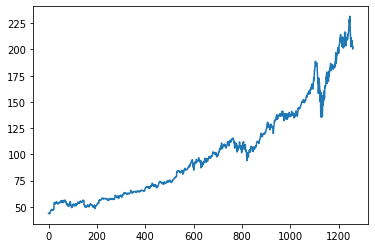

In [303]:
plt.plot(close)
plt.show()

In [304]:
T = 15
X = []
Y = []
for t in range(len(close)-T):
    x = close[t:t+T]
    X.append(x)
    y = close[t+T]
    Y.append(y)

In [305]:
X = np.array(X).reshape(-1,T,1)
Y = np.array(Y).reshape(-1,1)

In [306]:
print("X.shape",X.shape, "Y.shape",Y.shape)

X.shape (1244, 15, 1) Y.shape (1244, 1)


In [307]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [308]:
### Define LSTM
class LSTM(nn.Module):
    def __init__(self, n_inputs, n_hiddens, n_rnnlayers, n_outputs, n_fc_hidden):
        super().__init__()
        self.D = n_inputs
        self.M = n_hiddens
        self.K = n_outputs
        self.L = n_rnnlayers
        
        self.lstm = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            batch_first=True
        )
        self.fc = nn.Linear(self.M, n_fc_hidden)
        self.fc2 = nn.Linear(n_fc_hidden, n_outputs)
        
    def forward(self, X):
        # Initial Hidden states and Cell states
        h0 = torch.zeros(self.L, X.shape[0], self.M).to(device)
        c0 = torch.zeros(self.L, X.shape[0], self.M).to(device)
        
        # get LSTM output
        # out is of size (N, T, M)
        out, _ = self.lstm(X,(h0,c0))
        
        # we only use h(t) at the final timestep
        out = F.relu(self.fc(out[:,-1,:]))
        out = self.fc2(out)
        return out

In [309]:
model = LSTM(n_inputs=1, n_hiddens=130, n_rnnlayers=3, n_outputs=1,n_fc_hidden=50)
model.to(device)

LSTM(
  (lstm): LSTM(1, 130, num_layers=3, batch_first=True)
  (fc): Linear(in_features=130, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)

In [310]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [311]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-T].astype(np.float32))
y_train = torch.from_numpy(Y[:-T].astype(np.float32))
X_test = torch.from_numpy(X[-T:].astype(np.float32))
y_test = torch.from_numpy(Y[-T:].astype(np.float32))

In [312]:
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

In [313]:
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200):
    # Storing losses.
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward Pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward Optimization
        loss.backward()
        optimizer.step()
        
        # Save loss
        train_losses[epoch] = loss.item()
        
        # Test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[epoch] = test_loss.item()
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}]. Train loss : {loss.item():.3f}. Test loss : {test_loss.item():.3f}')
            

    return train_losses, test_losses

In [314]:
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=3000)

Epoch [100/3000]. Train loss : 3075.348. Test loss : 20684.514
Epoch [200/3000]. Train loss : 1912.974. Test loss : 12215.176
Epoch [300/3000]. Train loss : 1912.907. Test loss : 12268.818
Epoch [400/3000]. Train loss : 1912.907. Test loss : 12269.082
Epoch [500/3000]. Train loss : 1912.906. Test loss : 12269.077
Epoch [600/3000]. Train loss : 1912.903. Test loss : 12269.073
Epoch [700/3000]. Train loss : 1912.420. Test loss : 12267.984
Epoch [800/3000]. Train loss : 119.287. Test loss : 2412.028
Epoch [900/3000]. Train loss : 15.291. Test loss : 374.226
Epoch [1000/3000]. Train loss : 6.928. Test loss : 140.976
Epoch [1100/3000]. Train loss : 5.486. Test loss : 102.429
Epoch [1200/3000]. Train loss : 5.156. Test loss : 95.611
Epoch [1300/3000]. Train loss : 4.974. Test loss : 93.163
Epoch [1400/3000]. Train loss : 4.833. Test loss : 91.640
Epoch [1500/3000]. Train loss : 4.728. Test loss : 85.302
Epoch [1600/3000]. Train loss : 4.522. Test loss : 82.862
Epoch [1700/3000]. Train loss :

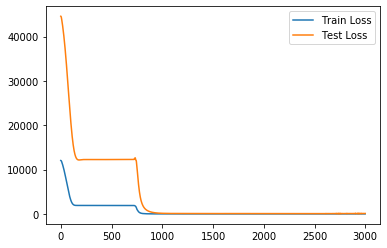

In [315]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()

In [316]:
# "Wrong" forecast using true target
validation_target = Y[-T:]
validation_predictions = []

# index of first validation input
i = 0

while len(validation_predictions) < len(validation_target):
    input_ = X_test[i].reshape(1, T, 1)
    p = model(input_)[0,0].item()
    i += 1
    
    # Update the prediction list
    validation_predictions.append(p)

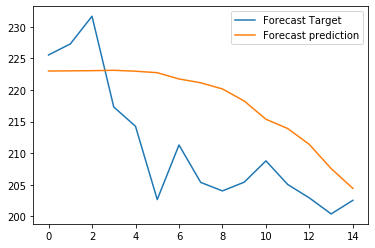

In [317]:
plt.plot(validation_target, label='Forecast Target')
plt.plot(validation_predictions, label='Forecast prediction')
plt.legend()
plt.show()

In [318]:
validation_target = Y[-T//2:]
validation_predictions = []

last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1,T,1)
    p = model(input_)
    # [0, 0]. 1 x 1 array -> scalar
    
    # Update the prediction list
    validation_predictions.append(p[0,0].item())
    
    last_x = torch.cat((last_x[1:], p[0]))

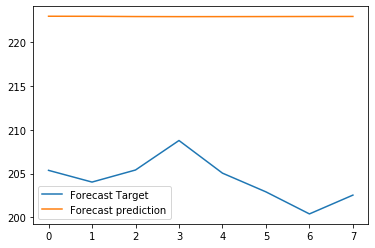

In [319]:
plt.plot(validation_target, label='Forecast Target')
plt.plot(validation_predictions, label='Forecast prediction')
plt.legend()
plt.show()